In [1]:
library(mgc)
library(reshape2)
library(ggplot2)

In [2]:
plot_sim_func <- function(X, Y, Xf, Yf, name, geom='line') {
  if (!is.null(dim(Y))) {
    Y <- Y[, 1]
    Yf <- Yf[, 1]
  }
  if (geom == 'points') {
    funcgeom <- geom_point
  } else {
    funcgeom <- geom_line
  }
  data <- data.frame(x1=X[,1], y=Y)
  data_func <- data.frame(x1=Xf[,1], y=Yf)
  ggplot(data, aes(x=x1, y=y)) +
    funcgeom(data=data_func, aes(x=x1, y=y), color='red', size=3) +
    geom_point() +
    xlab("x") +
    ylab("y") +
    ggtitle(name) +
    theme_bw()
}
plot_mtx <- function(Dx, main.title="Local Correlation Map", xlab.title="# X Neighbors", ylab.title="# Y Neighbors") {
  data <- melt(Dx)
  ggplot(data, aes(x=Var1, y=Var2, fill=value)) +
    geom_tile() +
    scale_fill_gradientn(name="l-corr",
                         colours=c("#f2f0f7", "#cbc9e2", "#9e9ac8", "#6a51a3"),
                         limits=c(min(Dx), max(Dx))) +
    xlab(xlab.title) +
    ylab(ylab.title) +
    theme_bw() +
    ggtitle(main.title)
}

In [3]:
set.seed(12345)
dat <- read.csv("hbn_vertexstats.csv", header = TRUE)
Y1 <- dat[,2]
Y2 <- dat[,3]
Y2 <- Y2 > 10.5
Y2 <- as.numeric(Y2)
print(Y1)

 [1] 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
[39] 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1
[77] 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0


In [4]:
zeromat <- matrix(1:288, nrow = 288, ncol=6)
mgctests <- array(0L, dim(zeromat))

count <- 1

for(i in 4:291){
  X <- dat[,i]
  Xdat <- array(as.numeric(unlist(X)), dim=c(91,1))
  YDat <- array(as.numeric(unlist(Y1)), dim=c(91,1))
  res <- mgc.test(Xdat,YDat, rep=20)
  val <- res$statMGC
  p_val <- res$pMGC
  scale <- res$optimalScale

  mgctests[count,1] = val
  mgctests[count,2] = 'Xdat'
  mgctests[count,3] = 'YDat'
  mgctests[count,4] = p_val
  mgctests[count,5] = scale$x
  mgctests[count,6] = scale$y
  count <- count +1
}


-0.0104743065556026,Xdat,YDat,0.7,39,2
-0.00617893736562363,Xdat,YDat,0.55,37,2
-0.00113956884347074,Xdat,YDat,0.3,39,2
-0.0041998132737221,Xdat,YDat,0.6,33,2
-0.00619802039919087,Xdat,YDat,0.55,44,2
0.0253393604616942,Xdat,YDat,0.05,47,2
-0.015089345772053,Xdat,YDat,1,46,2
-0.0133142100843102,Xdat,YDat,0.85,44,2
-0.00211508842493688,Xdat,YDat,0.5,44,2
-0.0139354604123615,Xdat,YDat,0.9,47,2
-0.00820964092146232,Xdat,YDat,0.5,48,2


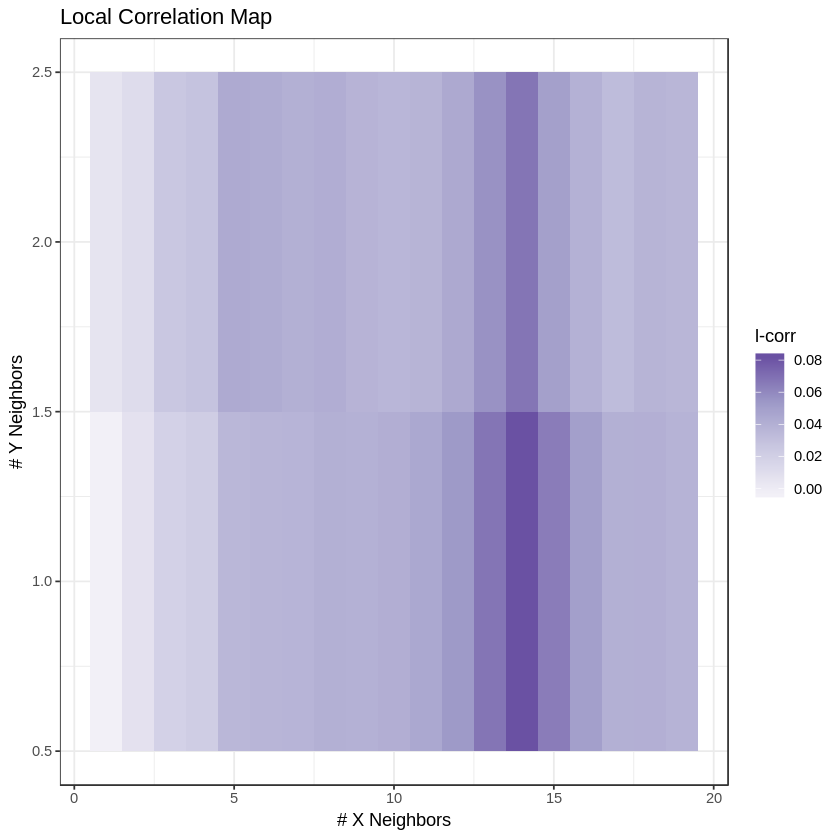

In [5]:
Xdat <- array(as.numeric(unlist(dat[,286])), dim=c(91,1))
YDat <- array(as.numeric(unlist(Y1)), dim=c(91,1))
res <- mgc.test(Xdat,YDat, rep=20)
corr_mat <- res$localCorr
write.csv(corr_mat, file = 'Gender_vertex_corr.csv')
write.csv(mgctests, file = 'mgc-test-stats_gender_vertex.csv')

In [6]:
zeromat <- matrix(1:288, nrow = 288, ncol=6)
mgctests <- array(0L, dim(zeromat))

count <- 1

#Xlist <- list(X1, X2, X3, X4, X5, X6)
for(i in 4:291){
  X <- dat[,i]
  Xdat <- array(as.numeric(unlist(X)), dim=c(91,1))
  YDat <- array(as.numeric(unlist(Y2)), dim=c(91,1))
  res <- mgc.test(Xdat,YDat, rep=20)
  val <- res$statMGC
  p_val <- res$pMGC
  scale <- res$optimalScale

  mgctests[count,1] = val
  mgctests[count,2] = 'Xdat'
  mgctests[count,3] = 'YDat'
  mgctests[count,4] = p_val
  mgctests[count,5] = scale$x
  mgctests[count,6] = scale$y
  count <- count +1
}

In [7]:
Xdat <- array(as.numeric(unlist(dat[,119])), dim=c(91,1))
YDat <- array(as.numeric(unlist(Y2)), dim=c(91,1))
res <- mgc.test(Xdat,YDat, rep=20)
corr_mat <- res$localCorr
write.csv(corr_mat, file = 'Age_vertex_corr.csv')

write.csv(mgctests, file = 'mgc-test-stats_age_vertex.csv')


In [8]:
set.seed(12345)
dat <- read.csv("hbn_vertexstats.csv", header = TRUE)
#dat <- array(as.numeric(unlist(dat)), dim=c(91,291))
Y1 <- dat[,2]
Y2 <- dat[,3]
Y2 <- Y2 > 10.5
Y2 <- as.numeric(Y2)
print(Y1)
X1 <- dat[,c(4:51)]
X2 <- dat[,c(52:99)]
X3 <- dat[,c(100:147)]
X4 <- dat[,c(148:195)]
X5 <- dat[,c(196:243)]
X6 <- dat[,c(244:291)]

 [1] 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
[39] 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1
[77] 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0


In [9]:
zeromat <- matrix(1:6, nrow = 6, ncol=6)
mgctests <- array(0L, dim(zeromat))

count <- 1

Xlist <- list(X1, X2, X3, X4, X5, X6)
for(i in Xlist){
  Xdat <- array(as.numeric(unlist(i)), dim=c(91,48))
  YDat <- array(as.numeric(unlist(Y1)), dim=c(91,1))
  res <- mgc.test(Xdat,YDat, rep=20)
  val <- res$statMGC
  p_val <- res$pMGC
  scale <- res$optimalScale

  mgctests[count,1] = val
  mgctests[count,2] = 'Xdat'
  mgctests[count,3] = 'YDat'
  mgctests[count,4] = p_val
  mgctests[count,5] = scale$x
  mgctests[count,6] = scale$y
  count <- count +1
}


In [10]:
Xdat <- array(as.numeric(unlist(X1)), dim=c(91,1))
YDat <- array(as.numeric(unlist(Y1)), dim=c(91,1))
res <- mgc.test(Xdat,YDat, rep=20)
corr_mat <- res$localCorr
write.csv(corr_mat, file = 'Gender_feature_corr.csv')

write.csv(mgctests, file = 'mgc-test-stats_gender_feature.csv')


In [11]:
zeromat <- matrix(1:6, nrow = 6, ncol=6)
mgctests <- array(0L, dim(zeromat))

count <- 1

#Xlist <- list(X1, X2, X3, X4, X5, X6)
for(i in Xlist){
  Xdat <- array(as.numeric(unlist(i)), dim=c(91,48))
  YDat <- array(as.numeric(unlist(Y2)), dim=c(91,1))
  res <- mgc.test(Xdat,YDat, rep=20)
  val <- res$statMGC
  p_val <- res$pMGC
  scale <- res$optimalScale

  mgctests[count,1] = val
  mgctests[count,2] = 'Xdat'
  mgctests[count,3] = 'YDat'
  mgctests[count,4] = p_val
  mgctests[count,5] = scale$x
  mgctests[count,6] = scale$y
  count <- count +1
}

In [12]:
Xdat <- array(as.numeric(unlist(X4)), dim=c(91,1))
YDat <- array(as.numeric(unlist(Y2)), dim=c(91,1))
res <- mgc.test(Xdat,YDat, rep=20)
corr_mat <- res$localCorr
write.csv(corr_mat, file = 'Age_feature_corr.csv')


write.csv(mgctests, file = 'mgc-test-stats_age_feature.csv')